# MEDT4165 Deep Learning Exercise
This notebook contains the code necessary to setup deep learning segmentation (training and evaluation) of ultrasound images. We will use the CAMUS dataset,
which is an open dataset containing echocardiograms from real patients. You can read more about the CAMUS project here: https://www.creatis.insa-lyon.fr/Challenge/camus/scientificInterests.html

CAMUS contains manually annotated segmentation masks for each ultrasound image.
Three heart structures are annotated: the *left ventricle*, the *left ventricular wall* and the *left atrium*. These are key structures in the heart, and their shapes and sizes can reveal a lot about the patient's cardiac health.

In this notebook, we will design, train and evaluate a deep neural network to automatically segment the anatomical structures in echocardiograms. The notebook already contains an implementation of a fully functional machine learning pipeline. Although the code runs without modifications, and provides you with a working segmentation model in the end, it has some potential for improvement.

Your task is to use what you've learnt so far to make improvements to the code in order to achieve a higher segmentation accuracy. There's a lot that can be improved: hyperparameter settings, network architecture, data preprocessing and augmentation. See what you can do to make improvements! You might need to seek some knowledge from the internet.

## Import the necessary python libraries
All of these libraries are already installed in the Google Colab environment. If you have downloaded this notebook to your local machine you might need to install some of these libraries first. The best way to do this is to create a *virtual environment* using *miniconda* and install the packages with *pip*. Then you can set the *interpreter* of the notebook to be you virtual enviroment.

In [ ]:
import os
import shutil
import gdown
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from matplotlib.colors import Normalize, ListedColormap

# Define a transparent colormap which we'll use for visualization of the segmentation masks
alpha = 0.3  # opacity (30 %)
cmap = ListedColormap([
    (0, 0, 0, 0),  # Class 0 (background) - Fully transparent
    (1, 0, 0, alpha),  # Class 1 (left ventricle) - Red
    (0, 1, 0, alpha),  # Class 2 (left ventricular wall) - Green
    (0, 0, 1, alpha)   # Class 3 (left atrium) - Blue
])

## Download and unpack CAMUS dataset (this might take a while)

In [ ]:
filename = "CAMUS_trainval_dataset.hdf5.zip"
id = "12_XhQALTeAqi3jFL3zQPnaNt-nlZv1UB"
gdown.download(id=id, output=filename, quiet=False)
shutil.unpack_archive(filename, '.', 'zip')

Downloading...
From (original): https://drive.google.com/uc?id=12_XhQALTeAqi3jFL3zQPnaNt-nlZv1UB
From (redirected): https://drive.google.com/uc?id=12_XhQALTeAqi3jFL3zQPnaNt-nlZv1UB&confirm=t&uuid=9fdd29a7-7482-474e-9ff0-01313899feb1
To: /content/CAMUS_trainval_dataset.hdf5.zip
100%|██████████| 516M/516M [00:08<00:00, 57.6MB/s]


## Access the image data
We can access the dataset with the *data* variable defined below. This variable is a reference to the hdf5 dataset on disk which can be used to index and load the data.
Then we can sample one image pair from the and have a look at it. Each ultrasound image is a 384x384x1 array with pixel values. The segmentation mask is a 384x384x1 array with pixel values in the range [0,1,2,3], one value for each class. (0: background, 1: left ventricle, 2: left ventricular wall, 3: left atrium).

In [ ]:
data = h5py.File("./CAMUS_trainval_dataset.hdf5", "r")

N_IMAGES = data["images"].shape[0]
print(data.keys())
print('Number of training + validation images: {}'.format(N_IMAGES))

<KeysViewHDF5 ['images', 'masks']>
Number of training + validation images: 1800


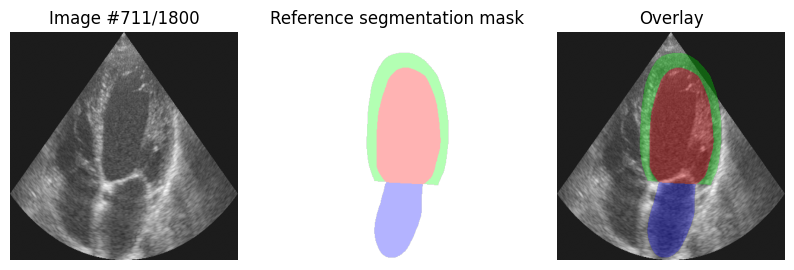

In [ ]:
i = np.random.randint(0, N_IMAGES)

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(data["images"][i, ..., 0], cmap='gray')
plt.title(f'Image #{i+1}/{N_IMAGES}')
plt.axis('off')
plt.subplot(132)
plt.imshow(data["masks"][i, ..., 0], cmap=cmap)
plt.title('Reference segmentation mask')
plt.axis('off')
plt.subplot(133)
plt.imshow(data["images"][i, ..., 0], cmap='gray')
plt.imshow(data["masks"][i, ..., 0], cmap=cmap)
plt.title('Overlay')
plt.axis('off')
plt.show()

## Define some useful functions
In the code block below, we define two important things:
- *The Dice coefficient*: This is the standard metric for evaluating segmentation performance. It can be quite useful to estimate how well your segmentation model performs. The *Dice coefficient* measures the degree of overlap between the predicted segmentation mask and the reference segmentation mask. It has a range [0, 1], where 1 indicates that the predicted segmentation mask perfectly overlaps the reference mask. A value of 0 indicates that there are absolutely no overlapping pixels for a given class.

- *Data generator*: A data generator is a useful way to handle your dataset. It prevents you from having to load the entire dataset into memory. In our case, the dataset is about 2GB, so we would like to avoid using 2GB RAM just to load data. With a generator, you can elegantly load the dataset in batches both during training and evaluation with limited RAM utilization. Moreover, we can define some preprocessing steps inside the generator:
    - *Resizing*: We resize the images to a smaller size to reduce computational cost. Image size should be a factor of 2 for ideal performance.
    - *Normalizing*: We ensure that the image pixel values are in the range [0,1] to avoid "exploding gradients" (numerical instabillity) during training.
    - *One-hot encoding*: When training the model it is more useful for the masks to be *one-hot encoded*. This means that, instead of each class label being encoded in the pixels with values 0, 1, 2 and 3 (as they are in the original hdf file), we would like them to be binary values (0/1), but across four different channels.
    - *Data augmentation*: This is *not implemented*, but it is fairly straightforward to add data augmentation in tensorflow once you have defined a data generator. Maybe this is something worth investigating?

In [ ]:
def dice(y_true, y_pred, skip_background=True, smooth=1e-6, axis=(0,1,2)):
    """
    Implements the Dice Coefficient between two from one-hot encoded tensors `y_true` and `y_pred`.
    If the background class is included in the tensors it must be skipped using `skip_background=True`, otherwise the dice coefficient will be incorrectly calculated.
    The "smooth" parameter prevents division by zero.
    axis specifies the axis for which the computation is averaged over. Default is (0,1,2), which gives one value per class (dimension 3)
    """

    assert y_true.ndim == y_pred.ndim == 4, "Incorrect number of dimensions. Expected 4 (batch, height, width, channels)"

    if skip_background:
        y_true = y_true[..., 1:]
        y_pred = y_pred[..., 1:]

    intersection = tf.math.reduce_sum(y_true * y_pred, axis=axis) + smooth
    union = tf.math.reduce_sum(y_true, axis=axis) + tf.math.reduce_sum(y_pred, axis=axis) + smooth
    return 2 * intersection / union

def normalize(img):
  minval = tf.math.reduce_min(img)
  maxval = tf.math.reduce_max(img)
  return (img - minval) / (maxval - minval)

def to_categorical(mask):
    """Convert one-hot encoded mask to categorical mask for visualization."""
    return np.argmax(mask, axis=-1)

# Generator function
def data_generator(images, masks, image_size):
    """Generator function to load image-mask pairs from HDF5 dataset."""
    assert image_size[0] <= images.shape[1] and image_size[1] <= images.shape[2], "IMAGE_SIZE cannot be larger than the original image size."

    for i in range(len(images)):

        # Resize images
        img = tf.image.resize(images[i], image_size, method=tf.image.ResizeMethod.BILINEAR)
        mask = tf.image.resize(masks[i], image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        # Normalize images to [0,1]
        img = normalize(img)

        # Encode masks from categorical (1,2,3) to binary values (One-hot encoding)
        mask = tf.cast(mask, tf.uint8)  # Convert resized mask to integer values
        mask = tf.squeeze(mask, axis=-1)  # Remove unnecessary last dimension
        mask = tf.one_hot(mask, depth=4)  # One-hot encode mask with 3 classes + background
        yield img, mask


# Wrap the generator with tf.data.Dataset
def get_tf_dataset(images, masks, batch_size=32, image_size=(128,128), shuffle=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(images, masks, image_size),
        output_signature=(
            tf.TensorSpec(shape=(*image_size, 1), dtype=tf.float32),  # Image shape
            tf.TensorSpec(shape=(*image_size, 4), dtype=tf.float32)  # Mask shape
        )
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


## Create data generators for training and validation
Before creating the generators, we need to decide how to split our data into *training and validation sets*.
The training set is the data that the model uses to adapt its weights during training. The validation set is used only to test the model performance and can be used to monitor the generalization of the model during training. In the end we can test our model on the validation set to get an impression of the model performance before we submit it for testing on the external test set. The *validation split* is the fraction of the total dataset that will be withheld for the validation set. Increasing the fraction will provide us with more data to validate on, which will give a better estimate of the model performance. However, we also need to keep most of the data for training to maintain a high performance, so you should keep the validation split fraction relatively low.

We create one generator for the training set, and one for the validation set. We can define the image size and the *batch size*, i.e. the number of images that are sampled and put into memory at once. After defining the generators, we can sample a batch from the training set generator and plot all the images.

In [ ]:
VALIDATION_SPLIT = 0.5

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 16

# Compute number of images in each set given validation split fraction
N_VAL = int(N_IMAGES * VALIDATION_SPLIT)
N_TRAIN = N_IMAGES - N_VAL

# Create TensorFlow datasets (use first N_VAL elements for validation)
train_dataset = get_tf_dataset(data["images"][N_VAL:], data["masks"][N_VAL:], batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True)
val_dataset = get_tf_dataset(data["images"][:N_VAL], data["masks"][:N_VAL], batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True)

# Verify dataset structure
for img, mask in train_dataset.take(1):
    print("Image batch shape:", img.shape, "Min:", np.min(img), "Max:", np.max(img))
    print("Mask batch shape:", mask.shape, "Min:", np.min(mask), "Max:", np.max(mask))

Image batch shape: (16, 128, 128, 1) Min: 0.0 Max: 1.0
Mask batch shape: (16, 128, 128, 4) Min: 0.0 Max: 1.0


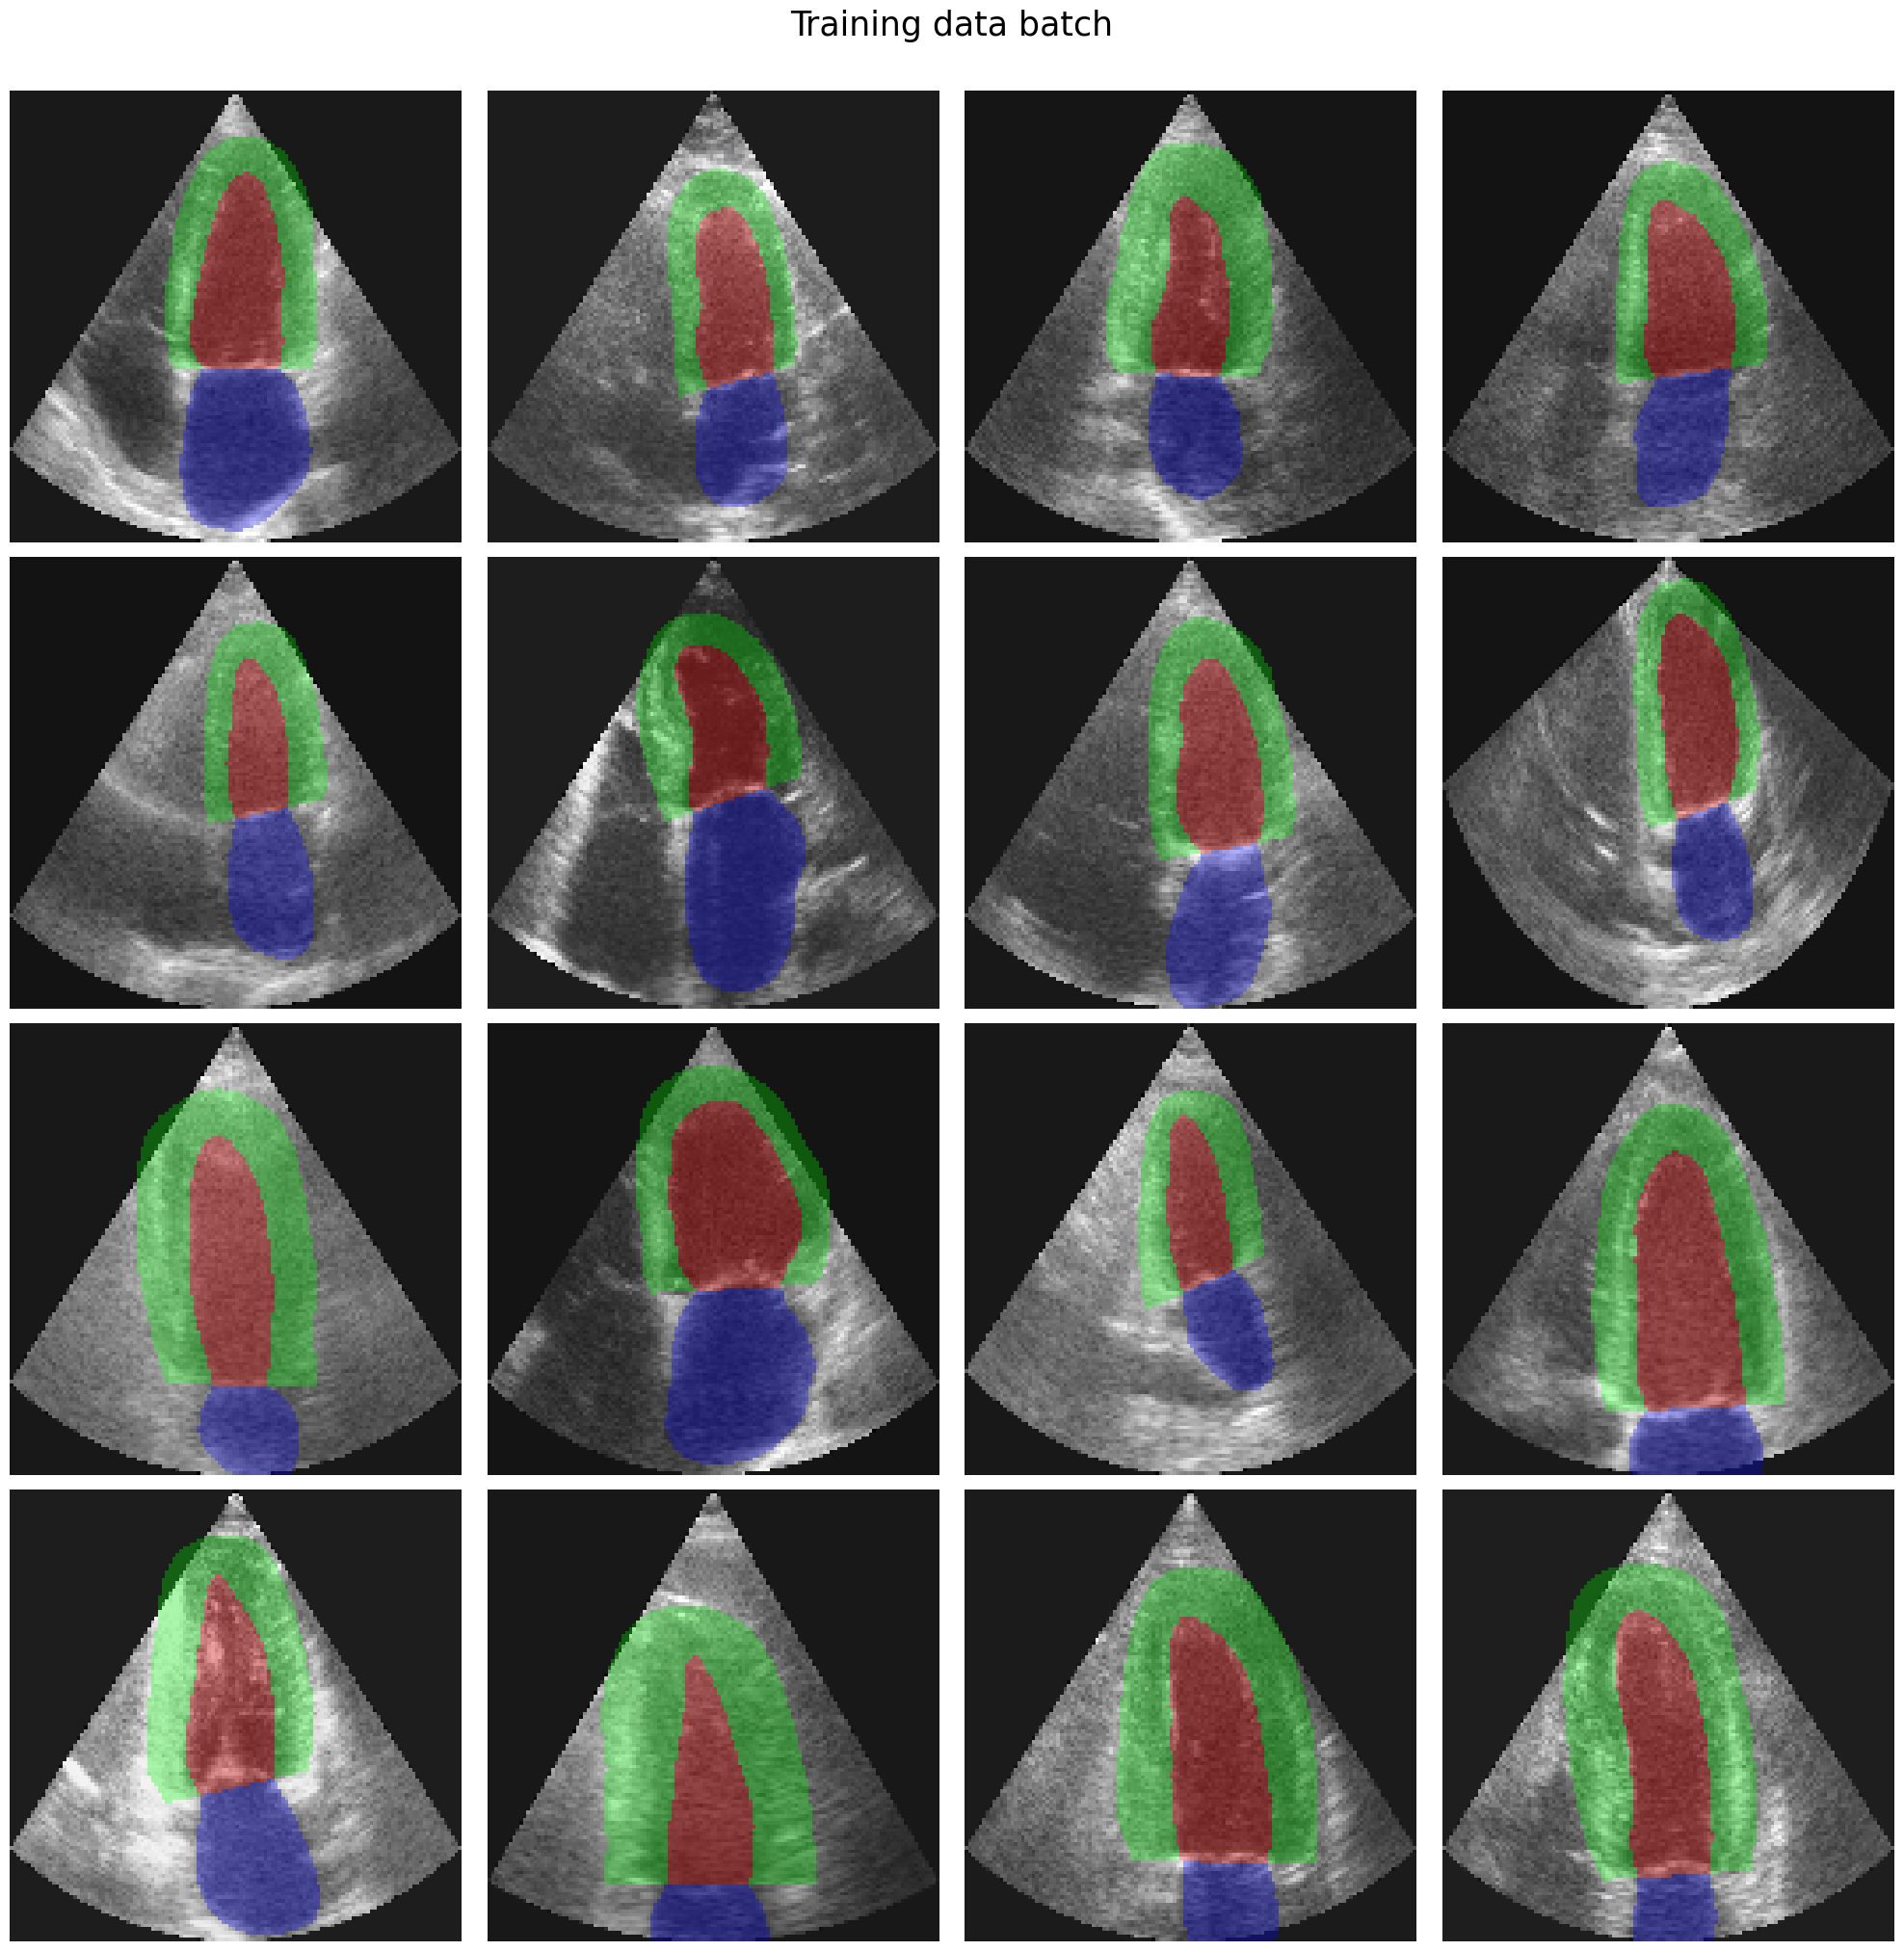

In [ ]:
# Take one batch from the dataset
for img, mask in train_dataset.take(1):

    # Plot each image with its corresponding mask
    n = np.ceil(np.sqrt(BATCH_SIZE)).astype(int)
    fig, axes = plt.subplots(n, n, figsize=(5*n, 5*n))  # (n x n) grid

    for i, ax in enumerate(axes.ravel()):
        ax.imshow(img[i, ...], cmap='gray')
        ax.imshow(to_categorical(mask[i]), cmap=cmap) # Overlay mask with transparency
        ax.axis('off')

plt.suptitle('Training data batch', fontsize=25, y=1.01)
plt.tight_layout()
plt.show()


## Define neural network architecture
In the following code cell we define the *architecture* of the neural network. Choosing a network architecture that is suited for the task is important, and can make a big difference on performance. You should consider what kind of layers make sense to use, and how to connect them. Moreover, you should consider the amount of layers (i.e. the networks depth), and the amount of parameters in each layer. Typically, creating a model with more layers and parameters leads to higher performance on the training dataset. However, it can quickly become too computationally demanding to train, and more importantly, it becomes more prone to *overfitting*. Overfitting would result in a poor performance on the test set, despite a high performance on the training set.

In our code we define a simple *autoencoder* network, which consists of some convolutional layers and pooling (downscaling), and upscaling layers. This seems to work ok, but you could perhaps find something better. Finding a good choice for the network architecture is not a trivial task, and you should probably try to find some inspiration from the internet. See what others have utilized for this segmentation task, and other segmentation tasks.

We also define the *loss function* and the *optimizer*. The loss function is how we quantify how close the model's prediction is to the reference for a given batch of images.
The model uses the information from the loss function to update its weights during training. Therefore, it is essential to make sure that the loss function aligns with what we want the model to learn. We choose the *cross entropy* function for this, as this is the standard loss function for segmentation, however, there exists other more exotic variants you might want to explore.
The optimizer defines how to update the weights based on the loss. There are some different ones we can use, but most people will tell you that *Adam* is the best option. Adam has some parameters you can play with, but it's probably wise to only mess with the *learning rate*, which affects how quickly the model weights will be updated during training. High learning rates can make your model learn faster, hence requiring less training epochs. But beware that setting it too high will throw the learning trajectory off track and your model will not be able to learn anything.

*Pro tip*: You can set *model.name* to keep track of different variants for storage later. Once you've designed your model you can call it something that sounds smart, like:
 "deep_US_HEARTseg_advanced_probabilistic_attention_extreme-former_net_infinity+1"


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Define a CNN segmentation model (Autoencoder)
def autoencoder(input_shape):
    inputs = Input(shape=input_shape) # Defines input layer (shape: H x W x 1)

    # Downsampling
    # Connects input layer to a Conv-layer with 16 feature maps and 3x3 conv-kernels. Returns output connection in variable 'x'.
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)  # output shape: H x W x 16
    x = MaxPooling2D((2, 2))(x) # Max-pooling layer with 2x2 kernel. Image dimensions are halved, leaving the maximum value from each 2x2 group of pixels.

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # output shape: H/2 x W/2 x 32
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # output shape: H/4 x W/4 x 64
    x = MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # output shape: H/8 x W/8 x 128

    # Upsampling
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # output shape: H/4 x W/4 x 64

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # output shape: H/2 x W/2 x 32

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) # output shape: H x W x 16

    # Output layer (4 classes, softmax activation)
    outputs = Conv2D(4, (1, 1), activation='softmax')(x) # output shape: H x W x 4

    model = tf.keras.models.Model(inputs, outputs)
    return model

model = autoencoder((*IMAGE_SIZE, 1))  # create new model
#model = tf.keras.models.load_model("./models/autoencoder.keras")  # Load from file to use a model you've previously trained
model.name = 'autoencoder'

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # the learning rate is set to the default value of Adam.
model.compile(optimizer=optimizer, loss="categorical_crossentropy",
              metrics=[dice])  # Metrics other than loss to keep track of during training. Keeping track of the dice score can be useful.
model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 4)    │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,100 (758.20 KB)

 Trainable params: 194,100 (758.20 KB)

 Non-trainable params: 0 (0.00 B)

## Train your model
Training the model with tensorflow/keras is pretty simple. All you do is call model.fit() with your generator. A key decision is to set the amount of *epochs* you want to train for. After one epoch, the model will have seen all the training data exactly once. Increase this number to allow the model to train for longer. Keep in mind that it will also take longer for it to finish training, and training for too long *may* cause overfitting.

The model.fit call returns a *history* object where the loss and metrics are logged for each epoch. We can plot these to inspect our training.

*Saving the model*: After training is finished, the model is saved in the *models* folder. You can then load this model for later use (for instance if you want to keep training for more epochs) using *tf.keras.models.load_model()*.

**BEWARE! If you are using Google Colab, all the data and saved model files will be deleted once you end the session. Therefore you should download the model files to your computer before ending the session. You can also mount your Google Drive to the Colab notebook and set your files to be stored inside your Google Drive.**

In [ ]:
EPOCHS = 5 # How many iterations the model sees the training dataset

steps_per_epoch = int( np.ceil(N_TRAIN / BATCH_SIZE) ) # leave unchanged
validation_steps = int( np.ceil(N_VAL / BATCH_SIZE) ) # leave unchanged

history = model.fit(train_dataset.repeat(),
                    validation_data=val_dataset.repeat(),
                    epochs=EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

os.makedirs('models', exist_ok=True)
model.save(f'./models/{model.name}.keras')
print('Model saved')

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 248ms/step - dice: 0.1116 - loss: 0.9883 - val_dice: 0.1942 - val_loss: 0.5638
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - dice: 0.2208 - loss: 0.5005 - val_dice: 0.2937 - val_loss: 0.4711
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - dice: 0.3537 - loss: 0.4097 - val_dice: 0.4513 - val_loss: 0.3816
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - dice: 0.5420 - loss: 0.3027 - val_dice: 0.5778 - val_loss: 0.3041
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - dice: 0.5991 - loss: 0.2705 - val_dice: 0.5993 - val_loss: 0.2872
Model saved


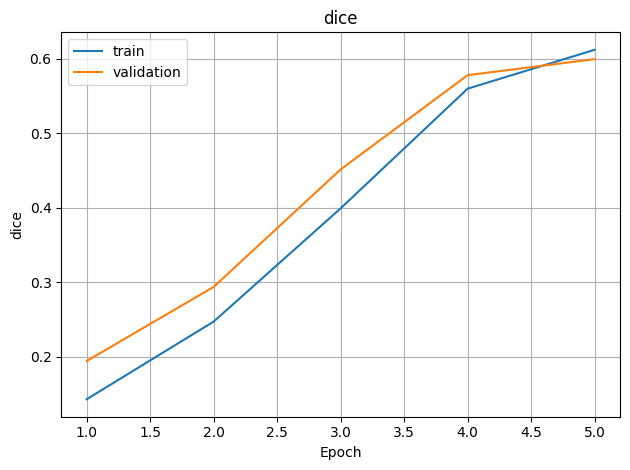

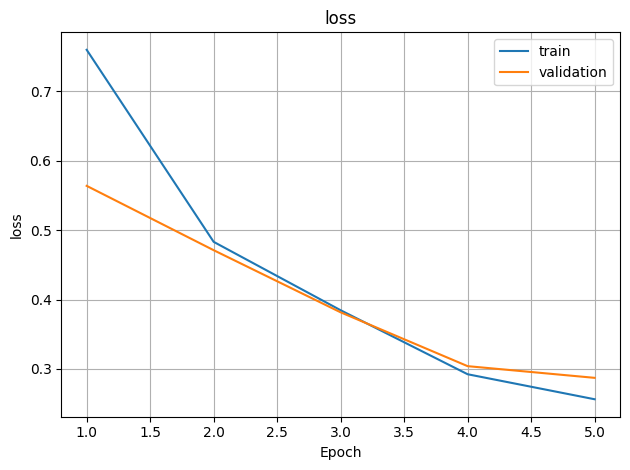

<Figure size 640x480 with 0 Axes>

In [ ]:
for key in history.history.keys():
    if 'val_' in key:
        continue
    train_metric = history.history[key]
    val_metric = history.history['val_' + key]
    epochs = np.arange(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, label='train')
    plt.plot(epochs, val_metric, label='validation')
    plt.xlabel('Epoch')
    plt.ylabel(key)
    #plt.ylim([0, max(max(train_metric), max(val_metric))])
    plt.title(key)
    plt.tight_layout()
    plt.grid()
    plt.legend()
    plt.show()

    # Save history plots in 'plots' folder
    os.makedirs('./plots', exist_ok=True)
    plt.savefig(f'./plots/{model.name}_{key}.png')


## Evaluate the model performance
Now that our model is trained, we can use it to do *inference* on the ultrasound images, i.e. predict the segmentation masks. This we can do with model.predict().
In the cell below, we sample one batch from the test data generator and predict the segmentation masks for the batch of images. Then we visualize the results along with the reference masks. Run the cell multiple times to see different samples.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


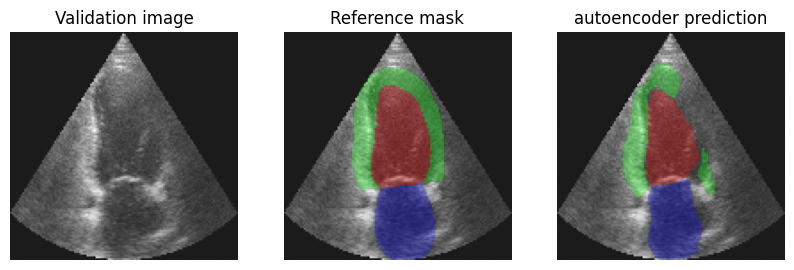

--- Evaluation of above image ---
Dice score (avg.): 0.7361
 -- Left ventricle: 0.8168
 -- Left ventricular wall: 0.5699
 -- Left atrium: 0.8216


In [ ]:
iterator = iter(val_dataset)
img, mask = iterator.get_next() # Get random batch from test dataset

prediction = model.predict(img) # Predict segmentation masks from images

index = np.random.randint(BATCH_SIZE) # Index in batch

# Visualize results of selected image pair
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(img[index, ..., 0], cmap='gray')
plt.title(f'Validation image')
plt.axis('off')
plt.subplot(132)
plt.imshow(img[index, ..., 0], cmap='gray')
plt.imshow(to_categorical(mask[index]), cmap=cmap)
plt.title('Reference mask')
plt.axis('off')
plt.subplot(133)
plt.imshow(img[index, ..., 0], cmap='gray')
plt.imshow(to_categorical(prediction[index] > 0.5), cmap=cmap)
plt.title(f'{model.name} prediction')
plt.axis('off')
plt.show()

# Compute the dice score for each class for the selected image
dsc = dice(prediction, mask, axis=(1,2))
print(f'--- Evaluation of above image ---')
print(f'Dice score (avg.): {np.mean(dsc[index]):.4f}')
print(f' -- Left ventricle: {dsc[index,0]:.4f}')
print(f' -- Left ventricular wall: {dsc[index,1]:.4f}')
print(f' -- Left atrium: {dsc[index,2]:.4f}')



Seems like our model has learned the task to some extent, but there is definitely room for improvement...

### Evaluate on all images

Finally, we compute the average dice score for all the images in our test set. We obtain a single value which we can use to quantify the performance of our model. We can compare it to other models and then determine which has the better performance.

In this exercise, we only care about the dice score for simplicity.
But keep in mind that in the real world, the dice score alone does not tell you everything about how useful the model is.
There are other image segmentation metrics you could use as well. Moreover, in the end we care about *clinical measurements*, which are derived from the segmentation masks. To truly determine if your model is useful, you should therefore look at how it can be used for making clinical measurements and how it compares to real world clinical assessment. But that is for another time...

In [ ]:
dsc = tf.zeros(3)
n_batches = 0
# Iterate through batches in test set and compute dice score for every class
for img, mask in val_dataset:
    prediction = model.predict(img, verbose=0)
    dsc += dice(prediction, mask)
    n_batches += 1
dsc /= n_batches

print('--- Evaluation of entire validation dataset ---')
print(f'Dice score (avg.): {np.mean(dsc):.4f}')
print(f' -- Left ventricle: {dsc[0]:.4f}')
print(f' -- Left ventricular wall: {dsc[1]:.4f}')
print(f' -- Left atrium: {dsc[2]:.4f}')



--- Evaluation of entire validation dataset ---
Dice score (avg.): 0.6013
 -- Left ventricle: 0.7213
 -- Left ventricular wall: 0.5317
 -- Left atrium: 0.5510


## Submission instructions

### Exercise submission
Make changes to this notebook with the goal to improve the model performance.
Your submission should be a .ipynb file based on this notebook. Remove/alter the existing markdown cells and document your changes.
You should not only state what changes you have made to the code, but motivate why you think it is a good idea (it does not actually have to make an improvement on model performance in the end, but the motivation should make sense).

- *Make an effort to document your changes, and make sure to reference your sources!* If you make major changes, such as implement some exotic architecture, you need to reference where you got this idea from. If you use LLMs to generate code, you should still try to figure out where the idea originated from (typically a research paper). You should not simply state "I did this because ChatGPT said it was a good idea".
- Make sure the notebook is free of bugs and is executable before submission.
- Please make an effort to make the notebook readable, with understandable code and elaborate markdown cells.

Here are some questions to consider when working with the notebook:
- How does changing the *hyperparameters* (epochs, batch size, image size, learning rate) impact the training phase?
- What are the trade-offs when changing the validation split?
- How do you interpret the training loss and accuracy curves?
- What strategies have been used for the CAMUS dataset in previous research?

### Participate in competition!
You can submit your best performing model to have it evaluated on the *test set* (which is unavailable to you).
The format must be the '.keras' format (see 'Train your model' for how to save the model).
After the submission deadline, all the submitted models will be evaluated on the test set. The results will be published on blackboard.
Make sure to name your model something unique such that it is distinguishable from the other model files. Also, make sure that your model loads and can be used for inference in the Google Colab notebook. If we are unable to load and/or run your model file then you will be disqualified from the competition. *Participation in the competition is voluntary*, but there will be a little price for whoever submits the best performing model.

### Submit files to blackboard
Upload the .ipynb file to Blackboard (Exercise 12).
To participate in the competition attach your best performing trained model (.keras file) in the assignment files.

### Cooperation and seeking help
Seeking help from the internet (including LLMs), as well as collaboration and helping each other is encouraged.
You likely have varied background knowledge and experience with deep learning and python programming. The goal of this exercise is to learn something new. If you are inexperienced we don't expect you to make advanced changes to this notebook, but everyone should be able to make some simple improvements, such as changing the values of the hyperparameters.
If you are already experienced with deep learning, feel free to explore some more advanced concepts.

The only thing that is *not* allowed is to actively cheat by downloading the test dataset from the CAMUS website and use it for training/validation. This is a cardinal sin in machine learning, as there should never be any leakage between the training and test sets!

#### Good luck!